In [33]:
# Импорт библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# Загрузка необработанного датасета
df = pd.read_csv('train_dataset_train.csv', sep=';')
df.head()

,PATIENT_SEX,MKB_CODE,ADRES,VISIT_MONTH_YEAR,AGE_CATEGORY,PATIENT_ID_COUNT
0,0,A00.0,Гурьевск,8.21,young,1
1,0,A00.0,Калининград,3.20,children,1
2,0,A00,Гусев,3.19,children,1
3,0,A00,Калининград,1.22,children,1
4,0,A00,Калининград,2.18,children,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212393 entries, 0 to 2212392
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   PATIENT_SEX       int64  
 1   MKB_CODE          object 
 2   ADRES             object 
 3   VISIT_MONTH_YEAR  float64
 4   AGE_CATEGORY      object 
 5   PATIENT_ID_COUNT  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 101.3+ MB


In [4]:
# Приведение колонки к правильному типу
df['VISIT_MONTH_YEAR'] = df['VISIT_MONTH_YEAR'].astype(str)

In [5]:
# Распределение
df['PATIENT_SEX'].value_counts()

0    1316709
1     895684
Name: PATIENT_SEX, dtype: int64

In [6]:
# Разделение колонки месяц_год на составляющие
def split_month_year(df):
    for i, col in enumerate(['MONTH', 'YEAR']):
        df[col] = df['VISIT_MONTH_YEAR'].apply(lambda x: int(x.split('.')[i]))
    df.drop('VISIT_MONTH_YEAR', axis=1, inplace=True)

split_month_year(df)

In [7]:
# Уникальные года в датасете
df['YEAR'].unique()

array([21,  2, 19, 22, 18], dtype=int64)

In [8]:
# Небольшое изменение формата МКБ-кодов, потом понадобится
import re

def fix_mkb_code(df):
    df['MKB_CODE'] = df['MKB_CODE'].apply(
        lambda x: x if re.search('[A-Z]\d{2}.\d', x) is not None else x + '.0')
fix_mkb_code(df)

In [9]:
df['ADRES'].value_counts()

Калининград           617129
Гурьевск              116111
Светлый                85748
Пионерский             84932
Советск                78466
                       ...  
Ясная Поляна            2670
Малинники               2649
Гурьевский              2635
СТ Радуга               2588
СТ Железнодорожник      2517
Name: ADRES, Length: 118, dtype: int64

In [10]:
# Добавление колонки сезона
def get_season(month):
    if month in [12, 1, 2]:
        return 1
    elif 3 <= month <= 5:
        return 2
    elif 6 <= month <= 8:
        return 3
    return 4

def get_season_col(df):
    df['SEASON'] = df['MONTH'].apply(lambda x: get_season(x))

get_season_col(df)

In [11]:
# Разделение МКБ-кодов на МКБ-группы

from string import ascii_uppercase

groups_str = [
    'A00-B99', 'C00-D48', 'D50-D89', 'E00-E90',
    'F00-F99', 'G00-G99', 'H00-H59', 'H60-H95',
    'I00-I99', 'J00-J99', 'K00-K93', 'L00-L99',
    'M00-M99', 'N00-N99', 'O00-O99', 'P00-P96',
    'Q00-Q99', 'R00-R99', 'S00-T98', 'V01-Y98',
    'Z00-Z99'
]

groups = []

for grs in groups_str:
    g1, g2 = grs.split('-')
    sub = []
    for g in [g1, g2]:
        l = ascii_uppercase.index(g[0])
        n = int(g[1:])
        sub.append((l, n))
    groups.append(sub)


def get_mkb_group(code):
    l = ascii_uppercase.index(code[0])
    n = int(code[1:])

    for i, group in enumerate(groups):
        if not (group[0][0] <= l <= group[1][0]):
            continue
        elif group[0][0] == l and n < group[0][1]:
            continue
        elif group[1][0] == l and n > group[1][1]:
            continue
        return i

    return np.nan


def get_mkb_group_col(df):
    df['MKB_GROUP'] = df['MKB_CODE'].apply(lambda x: get_mkb_group(x.split('.')[0]))

<AxesSubplot:>

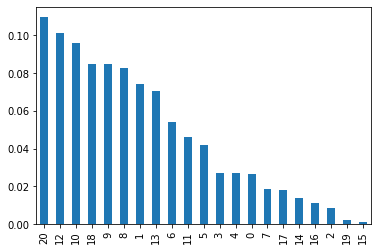

In [12]:
get_mkb_group_col(df)
df['MKB_GROUP'].value_counts(normalize=True).plot(kind='bar')

In [13]:
df.head()

,PATIENT_SEX,MKB_CODE,ADRES,AGE_CATEGORY,PATIENT_ID_COUNT,MONTH,YEAR,SEASON,MKB_GROUP
0,0,A00.0,Гурьевск,young,1,8,21,3,0
1,0,A00.0,Калининград,children,1,3,2,2,0
2,0,A00.0,Гусев,children,1,3,19,2,0
3,0,A00.0,Калининград,children,1,1,22,1,0
4,0,A00.0,Калининград,children,1,2,18,1,0


In [14]:
df['ADRES'].unique()

array(['Гурьевск', 'Калининград', 'Гусев', 'Нестеров', 'Партизанское',
       'Садовое', 'Славск', 'Ясная Поляна', 'Гвардейск', 'Холмогоровка',
       'Багратионовск', 'Большое Исаково', 'Зеленоградск',
       'Калининградская', 'Колосовка', 'Краснознаменск', 'Невское',
       'Неман', 'Пионерский', 'Правдинск', 'Прибрежный',
       'СТ Железнодорожник', 'СТ Искра ул. Тюльпановая', 'СТ Победа',
       'Светлый', 'Советск', 'Совхозное', 'Черняховск', 'Балтийск',
       'Малое Васильково', 'Полесск', 'Сосновка', 'Ладушкин', 'Малинники',
       'Раздольное', 'Озерск', 'Волочаевское', 'Мамоново', 'Нивенское',
       'Светлогорск', 'Васильково', 'Голубево', 'Долгоруково', 'Донское',
       'Дружный', 'Заозерье', 'Корнево', 'Ласкино', 'Луговое', 'Люблино',
       'Малиновка', 'Малое Исаково', 'Матросово', 'Озерки',
       'Переславское', 'Пятидорожное', 'СТ Колосок', 'СТ Радуга',
       'Саранское', 'Славинск', 'Славянское', 'Ушаково', 'Янтарный',
       'Ясное', 'Илюшино', 'Шоссейное', 'Южн

In [15]:
# Импорт инструмента для получения координат
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='myapp')

In [16]:
# Получение координат каждого из мест
locations = {}

for loc in df['ADRES'].unique():
    location = geolocator.geocode(f'Россия, Калининградская область, {loc}')
    if location is None:
        print('Location not found:', loc)
        continue
    locations[loc] = (location.latitude, location.longitude)

Location not found: СТ Искра ул. Тюльпановая


In [17]:
# Ручая задача места
locations['СТ Искра ул. Тюльпановая'] = (54.757112, 20.526514)

In [18]:
# Разделение мест на районы
ldf = pd.DataFrame([
    (loc, *locations[loc]) for loc in locations
], columns=['LOC', 'LAT', 'LON'])
ldf.head()

,LOC,LAT,LON
0,Гурьевск,54.774557,20.603704
1,Калининград,54.710128,20.510584
2,Гусев,54.592144,22.201521
3,Нестеров,54.632545,22.571100
4,Партизанское,54.592304,20.621603


<AxesSubplot:xlabel='LON', ylabel='LAT'>

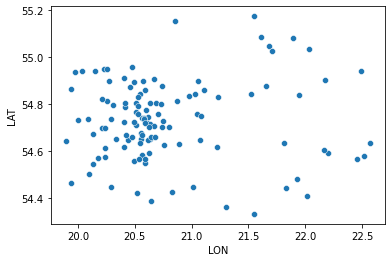

In [19]:
sns.scatterplot(data=ldf, y='LAT', x='LON')

<AxesSubplot:xlabel='LON', ylabel='LAT'>

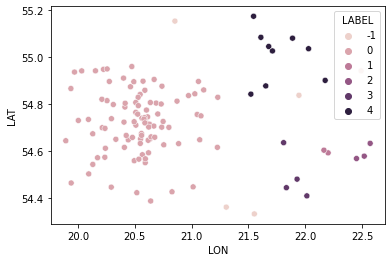

In [20]:
from sklearn.cluster import DBSCAN, KMeans

dbsc = DBSCAN(min_samples=2, eps=0.21).fit(ldf.filter(['LAT', 'LON']))
ldf['LABEL'] = dbsc.labels_

sns.scatterplot(data=ldf, y='LAT', x='LON', hue='LABEL')

In [21]:
ldf['LABEL'].value_counts()

 0    95
 4     9
-1     5
 3     4
 2     3
 1     2
Name: LABEL, dtype: int64

In [22]:
# Заполнение значений -1
idx = np.where(ldf['LABEL'] == -1)[0]
ldf.loc[idx, 'LABEL'] = np.arange(5, 10)

In [23]:
zones = dict([
    (row['LOC'], row['LABEL']) for row in ldf.iloc
])

for z, i in list(zones.items())[:10]:
    print(z, i)

Гурьевск 0
Калининград 0
Гусев 1
Нестеров 2
Партизанское 0
Садовое 3
Славск 4
Ясная Поляна 2
Гвардейск 0
Холмогоровка 0


In [24]:
# Создание колонки зоны
def get_zone_col(df):
    df['ZONE'] = df['ADRES'].apply(lambda x: zones[x])

get_zone_col(df)
df.head()

,PATIENT_SEX,MKB_CODE,ADRES,AGE_CATEGORY,PATIENT_ID_COUNT,MONTH,YEAR,SEASON,MKB_GROUP,ZONE
0,0,A00.0,Гурьевск,young,1,8,21,3,0,0
1,0,A00.0,Калининград,children,1,3,2,2,0,0
2,0,A00.0,Гусев,children,1,3,19,2,0,1
3,0,A00.0,Калининград,children,1,1,22,1,0,0
4,0,A00.0,Калининград,children,1,2,18,1,0,0


In [25]:
# Добавление новых колонок для тестового датасета
dft = pd.read_csv('test_dataset_test.csv', sep=';')
dft.head()

,PATIENT_SEX,MKB_CODE,ADRES,VISIT_MONTH_YEAR,AGE_CATEGORY
0,0,A00,Калининград,4.22,children
1,0,A00,Калининград,4.22,elderly
2,0,A00,Калининград,4.22,middleage
3,0,A00,Калининград,4.22,young
4,0,A01,Калининград,4.22,middleage


In [26]:
dft['VISIT_MONTH_YEAR'].unique()

array([4.22])

In [27]:
dft['VISIT_MONTH_YEAR'] = dft['VISIT_MONTH_YEAR'].astype(str)

In [28]:
split_month_year(dft)
fix_mkb_code(dft)
get_season_col(dft)
get_mkb_group_col(dft)
get_zone_col(dft)

In [29]:
dft['MKB_CODE'].unique()

array(['A00.0', 'A01.0', 'A02.0', ..., 'Z92.8', 'Z95.2', 'Z96.7'],
      dtype=object)

In [30]:
dft['MKB_GROUP'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int64)

In [31]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39373 entries, 0 to 39372
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PATIENT_SEX   39373 non-null  int64 
 1   MKB_CODE      39373 non-null  object
 2   ADRES         39373 non-null  object
 3   AGE_CATEGORY  39373 non-null  object
 4   MONTH         39373 non-null  int64 
 5   YEAR          39373 non-null  int64 
 6   SEASON        39373 non-null  int64 
 7   MKB_GROUP     39373 non-null  int64 
 8   ZONE          39373 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 2.7+ MB


In [32]:
# Добавление колонки времени
for tgt in [df, dft]:
    tgt['TIME'] = (tgt['YEAR'] - 2) * 12 + tgt['MONTH']
df.head()

,PATIENT_SEX,MKB_CODE,ADRES,AGE_CATEGORY,PATIENT_ID_COUNT,MONTH,YEAR,SEASON,MKB_GROUP,ZONE,TIME
0,0,A00.0,Гурьевск,young,1,8,21,3,0,0,236
1,0,A00.0,Калининград,children,1,3,2,2,0,0,3
2,0,A00.0,Гусев,children,1,3,19,2,0,1,207
3,0,A00.0,Калининград,children,1,1,22,1,0,0,241
4,0,A00.0,Калининград,children,1,2,18,1,0,0,194


In [34]:
# Удаление повторений
df_grouped = df.groupby(['MKB_CODE', 'ADRES', 'AGE_CATEGORY', 'PATIENT_SEX', 'TIME'])
rows = []

for group in tqdm(df_grouped.groups.keys()):
    sub_df = df_grouped.get_group(group)
    val = sub_df['PATIENT_ID_COUNT'].sum()
    row = sub_df.iloc[0].copy()
    row['PATIENT_ID_COUNT'] = val
    rows.append(row)

df = pd.DataFrame(rows).reset_index(drop=True)

100%|██████████| 2185535/2185535 [12:11<00:00, 2987.48it/s]


In [36]:
del df_grouped

In [40]:
# Сохранение всего в файлы
dft.to_csv('test.csv', index=False)
df.to_csv('train.csv', index=False)